### Empirical Example Three for RobustiPy!

#### This example is designed to show how the OLSRobust class can be used to estimate a model with longitudinal data.

To get access to this data, you'll need the Understanding Society: Longitudinal Teaching Dataset, Waves 1-9, 2009-2018 from [[here](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=8715#!/access-data)]. Registration is immediate for this. Documentation which accompanies it can be found [[here](https://doc.ukdataservice.ac.uk/doc/8715/mrdoc/pdf/8715_user_guide.pdf)].

You want to put this data somewhere like `.data/input`.

As always, lets load in some of the libraries which we'll need:

In [ ]:
%pip install git+https://github.com/robustipy/robustipy.git

In [102]:
import os
import numpy as np
import pandas as pd
from robustipy.models import OLSRobust

Then, load in the dataset (note: we are using the tab-seperated version, but they should all be equivilent):

In [103]:
df = pd.read_csv('longitudinal_td.tab', sep='\t', low_memory=False)

Let's quickly eyeball the data to see what we have:

In [104]:
df.pidp.value_counts()

pidp
1634625491    9
1634625487    9
68004087      9
68006127      9
68006807      9
             ..
1633798615    1
1633804727    1
1633810167    1
1633816287    1
1633816291    1
Name: count, Length: 36619, dtype: int64

Our main dependent variable of interest is sf1_dv: General health.

In [105]:
df['sf1_dv'] = pd.to_numeric(df['sf1_dv'], errors='coerce')

Then, we're going to binarise it so that good health is 3 or more (==1), zero otherwise:

In [106]:
df = df[df['sf1_dv']>0]
df['sf1_dv_good'] = np.where(df['sf1_dv']>=3, 1, 0)

Our grouping variable needs to be a string

In [107]:
df['pidp'] = df['pidp'].astype(str)

Let's convert our `sex_dv` variable into binary 1s and zeros:

<Axes: >

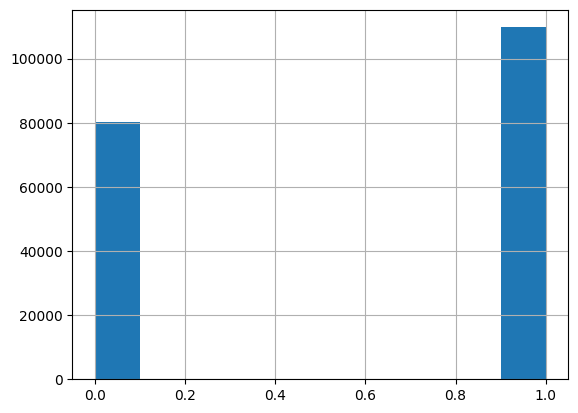

In [108]:
df['sex_dv'] = pd.to_numeric(df['sex_dv'], errors='coerce')
df['sex_dv'] = np.where(df['sex_dv']==2, 1, 0)
df['sex_dv'].hist()

Let's do something similar for cohab_dv, but this is already 1s and 0s:

In [109]:
df['cohab_dv'] = pd.to_numeric(df['cohab_dv'], errors='coerce')
df = df[df['cohab_dv']>=0]

<Axes: >

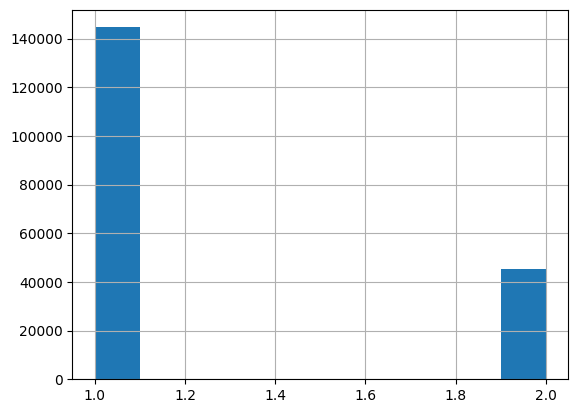

In [110]:
df['urban_dv'] = pd.to_numeric(df['urban_dv'], errors='coerce')
df = df[df['urban_dv']>0]
df['urban_dv'].hist()

Lets then – for simplicity and without failing to appreciate the complexity of this variable – dichotomize an additional variable (after cleaning it for missing/non-response). You can make something as simple as `is_british` (==1, 0 otherwise), or something more elaborate.

In [111]:
df['ethn_dv'] = pd.to_numeric(df['ethn_dv'], errors='coerce')
df = df[df['ethn_dv']>0]
df['is_british'] = np.where(df['ethn_dv']==1, 1, 0)

In [112]:
df['bmi_dv'] = pd.to_numeric(df['bmi_dv'], errors='coerce')
df = df[df['bmi_dv']>0]

In [113]:
df = df[df['hhsize_dv']>0]

In [114]:
df['age_dv'] = pd.to_numeric(df['age_dv'], errors='coerce')
df = df[df['age_dv']>0]

Let's next make a variable for whether an individual has a degree or not:

In [115]:
df['hiqual_dv'] = pd.to_numeric(df['hiqual_dv'], errors='coerce')
df['has_degree'] = np.where(df['hiqual_dv']==3, 1, 0)

Subset our dataframe for simplicity:

In [116]:
df = df.reset_index()
df = df[['sf1_dv_good', 'age_dv', 'sex_dv', 'cohab_dv', 'pidp', 'is_british', 'urban_dv', 'hhsize_dv']]
df.head(5)

,sf1_dv_good,age_dv,sex_dv,cohab_dv,pidp,is_british,urban_dv,hhsize_dv
0,0,39,0,0,68001367,1,1.0,1
1,0,59,0,0,68004087,0,1.0,1
2,1,39,1,1,68006127,1,1.0,4
3,1,72,1,0,68006807,1,1.0,1
4,0,57,1,0,68007487,1,1.0,4


What's the length?

In [117]:
len(df)

34230

Now let's drop and see if we lose any (we shouldnt, though! Why?)

In [118]:
#df = df.dropna()
print(len(df))

34230


Now what does our dataset look like?

In [119]:
df.head(5)

,sf1_dv_good,age_dv,sex_dv,cohab_dv,pidp,is_british,urban_dv,hhsize_dv
0,0,39,0,0,68001367,1,1.0,1
1,0,59,0,0,68004087,0,1.0,1
2,1,39,1,1,68006127,1,1.0,4
3,1,72,1,0,68006807,1,1.0,1
4,0,57,1,0,68007487,1,1.0,4


Lets quickly check the correlation matrix to check that nothing funky is going on:

In [120]:
df.corr()

,sf1_dv_good,age_dv,sex_dv,cohab_dv,pidp,is_british,urban_dv,hhsize_dv
sf1_dv_good,1.000000,0.208998,-0.001299,-0.028347,-0.009759,0.042729,-0.017000,-0.098832
age_dv,0.208998,1.000000,-0.018613,-0.203955,-0.001068,0.265207,0.142563,-0.433070
sex_dv,-0.001299,-0.018613,1.000000,-0.015608,-0.008472,0.019662,0.014392,0.014259
cohab_dv,-0.028347,-0.203955,-0.015608,1.000000,-0.009566,0.067149,-0.017806,0.046745
pidp,-0.009759,-0.001068,-0.008472,-0.009566,1.000000,-0.041170,-0.027662,0.013737
is_british,0.042729,0.265207,0.019662,0.067149,-0.041170,1.000000,0.207085,-0.218748
urban_dv,-0.017000,0.142563,0.014392,-0.017806,-0.027662,0.207085,1.000000,-0.049093
hhsize_dv,-0.098832,-0.433070,0.014259,0.046745,0.013737,-0.218748,-0.049093,1.000000


What data types do we have here?

In [121]:
df.dtypes

sf1_dv_good      int64
age_dv           int64
sex_dv           int64
cohab_dv         int64
pidp            object
is_british       int64
urban_dv       float64
hhsize_dv        int64
dtype: object

In [122]:
df['pidp'].value_counts()

pidp
1634649971    1
68001367      1
68004087      1
68006127      1
68006807      1
             ..
68039447      1
68040127      1
68041487      1
68042167      1
68042171      1
Name: count, Length: 34230, dtype: int64

Finally, lets call RobustiPy as we do in other examples, noting the group='pipd' call:

In [125]:
ukhls_robustipy = OLSRobust(y=['age_dv'],
                            x=['sex_dv'],
                            data=df.dropna())

Now, let's fit the model:

In [126]:
ukhls_robustipy.fit(controls=['cohab_dv',
                              'sex_dv',
                              'is_british',
                              'urban_dv',
                              'hhsize_dv',
                             ],
                   draws=10,
                   kfold=10,
                   group='pidp'
                   )

Output()

ValueError: Inputs must not be empty.

And, get the results:

In [ ]:
#ukhls_results = ukhls_robustipy.get_results()

In [ ]:
#ukhls_results.summary_df

Plot results:

In [ ]:
#ukhls_results.plot(figsize=(16, 12))

And print the summary statistic:

In [ ]:
#ukhls_results.summary()